### **Implementation of LeNet-5**

**Coder: Arka Roy**

**Website: [https://github.com/rsarka34](https://github.com/rsarka34)**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34/NPTEL-ML-DL-NOC24EE146/blob/main/NPTEL_Conv_AE_denoising.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## **Prepare the data**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


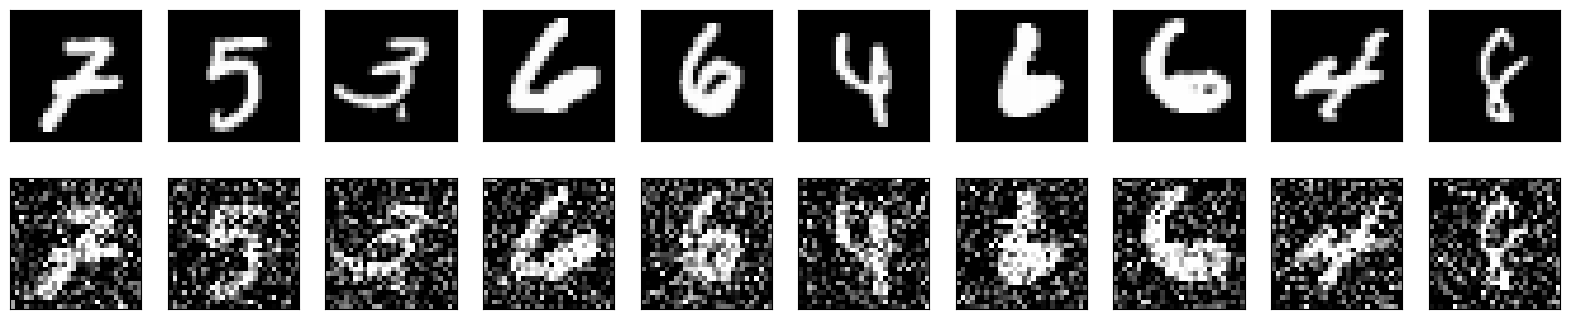

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## **Build the autoencoder**

***We are going to use the Functional API to build our convolutional autoencoder.***

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

**let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.**

In [5]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3033 - val_loss: 0.1055
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.1039 - val_loss: 0.0975
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0975 - val_loss: 0.0945
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0948 - val_loss: 0.0927
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0930 - val_loss: 0.0910
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0917 - val_loss: 0.0906
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0909 - val_loss: 0.0894
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0902 - val_loss: 0.0889
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0897 - val_loss: 0.0886
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0890 - val_loss: 0.0881
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0886 - val_loss: 0.0880
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/

In [ ]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


**Let's now predict on the noisy data and display the results of our autoencoder**

**Notice how the autoencoder does an amazing job at removing the noise from the
input images**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


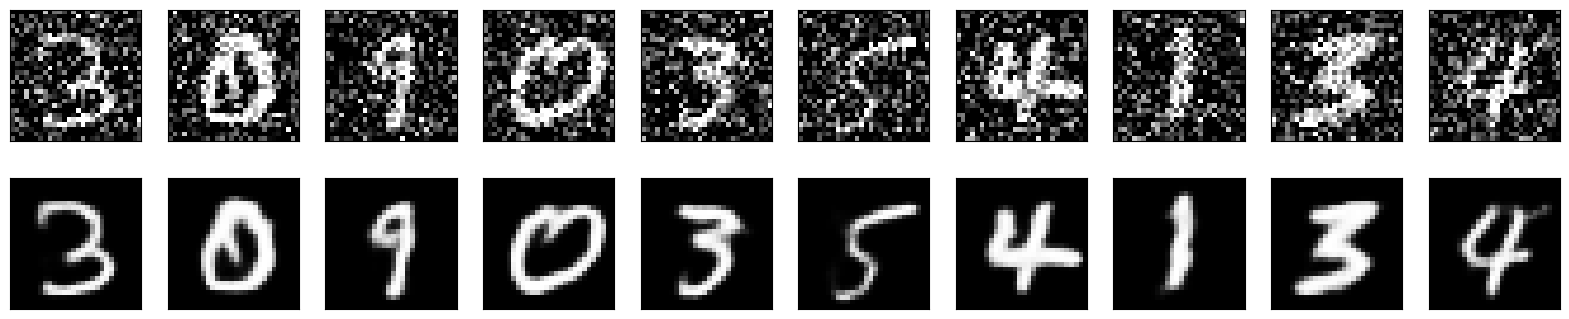

In [6]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)